# Importing data

In [1]:
!gdown https://drive.google.com/uc?id=1P12YAYLOg8T7x7beOkHozaPFsBRTFz5w

Downloading...
From: https://drive.google.com/uc?id=1P12YAYLOg8T7x7beOkHozaPFsBRTFz5w
To: /content/GTZAN Dataset - Music Genre Classification.zip
100% 1.30G/1.30G [00:25<00:00, 50.1MB/s]


In [ ]:
!unzip GTZAN\ Dataset\ -\ Music\ Genre\ Classification.zip

# Importing Libraries

In [22]:
import glob
import json
import os

import IPython.display as ipd
import keras
import librosa
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Extract the Feature of audio i.e MFCCs and append the data in the dictionary which contain the type of music, MFCCs and the label for the type of music

In [7]:
SAMPLE_RATE = 22050
DURATION = 30  # 30SEC
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

In [8]:
def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": []
    }

    for i, (dirpath, dirname, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath is not dataset_path:
            dirpath_components = dirpath.split('/')
            semantic_label = dirpath_components[-1]
            data["mapping"].append(semantic_label)
            print(f"\n Processing {semantic_label}")

            num_samples_per_segent = int(SAMPLES_PER_TRACK / num_segments)
            expected_num_mfcc_vectos_per_segment = np.ceil((num_samples_per_segent / hop_length))

            for f in filenames:
                file_path = os.path.join(dirpath, f)
                signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

                for s in range(num_segments):
                    start_sample = num_samples_per_segent * s
                    finish_sample = start_sample + num_samples_per_segent

                    mfcc = librosa.feature.mfcc(y=signal[start_sample:finish_sample],
                                                sr=sr,
                                                n_fft=n_fft,
                                                n_mfcc=n_mfcc,
                                                hop_length=hop_length

                                                )
                    mfcc = mfcc.T

                    if len(mfcc) == expected_num_mfcc_vectos_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i - 1)
    return data

In [9]:
jazz = glob.glob('/content/Data/genres_original/jazz/*.wav')
ipd.Audio(jazz[53])

In [10]:
DATASET_PATH = "/content/Data/genres_original"
JSON_PATH = "data.json"
data = save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)


 Processing blues

 Processing pop

 Processing reggae

 Processing disco

 Processing jazz

 Processing rock

 Processing classical

 Processing hiphop

 Processing metal

 Processing country


In [11]:
JSON_PATH = "data.json"
with open(JSON_PATH, "w") as fp:
    json.dump(data, fp, indent=4)

# Data to load form the Data.json dictonary

In [12]:
def load_data(data_path):
    """Loads training dataset from json file.

        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return X, y

In [13]:
x, y = load_data("/content/data.json")

Data succesfully loaded!


# Create simple neural network

In [14]:
# create train/test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [17]:
# build network topology


def build_simple_model(input_shape):
    model = keras.Sequential()

    # input layer
    model.add(keras.layers.Flatten(input_shape=input_shape))

    # 1st dense layer
    model.add(keras.layers.Dense(512, activation='relu'))

    # 2nd dense layer
    model.add(keras.layers.Dense(256, activation='relu'))

    # 3rd dense layer
    model.add(keras.layers.Dense(64, activation='relu'))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [24]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.tight_layout()
    plt.show()

In [18]:
input_shape = (x.shape[1], x.shape[2])
simple_model = build_simple_model(input_shape)
simple_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1690)              0         
                                                                 
 dense (Dense)               (None, 512)               865792    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 1014218 (3.87 MB)
Trainable params: 1014218 (3.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
simple_model.compile(optimizer=optimiser,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

In [21]:
# train model
history = simple_model.fit(x_train, y_train, validation_split=.2, batch_size=32, epochs=50)

Epoch 1/50
175/175 [==============================] - 8s 6ms/step - loss: 9.7343 - accuracy: 0.3094 - val_loss: 4.7347 - val_accuracy: 0.3598
Epoch 2/50
175/175 [==============================] - 1s 4ms/step - loss: 2.9829 - accuracy: 0.3555 - val_loss: 2.1430 - val_accuracy: 0.3405
Epoch 3/50
175/175 [==============================] - 1s 4ms/step - loss: 1.8170 - accuracy: 0.3965 - val_loss: 2.1408 - val_accuracy: 0.3526
Epoch 4/50
175/175 [==============================] - 2s 10ms/step - loss: 1.6353 - accuracy: 0.4326 - val_loss: 2.0454 - val_accuracy: 0.3569
Epoch 5/50
175/175 [==============================] - 2s 10ms/step - loss: 1.4876 - accuracy: 0.4889 - val_loss: 2.1363 - val_accuracy: 0.3777
Epoch 6/50
175/175 [==============================] - 1s 4ms/step - loss: 1.4040 - accuracy: 0.5048 - val_loss: 2.0612 - val_accuracy: 0.3763
Epoch 7/50
175/175 [==============================] - 1s 4ms/step - loss: 1.2921 - accuracy: 0.5506 - val_loss: 2.1005 - val_accuracy: 0.3913
Epoc

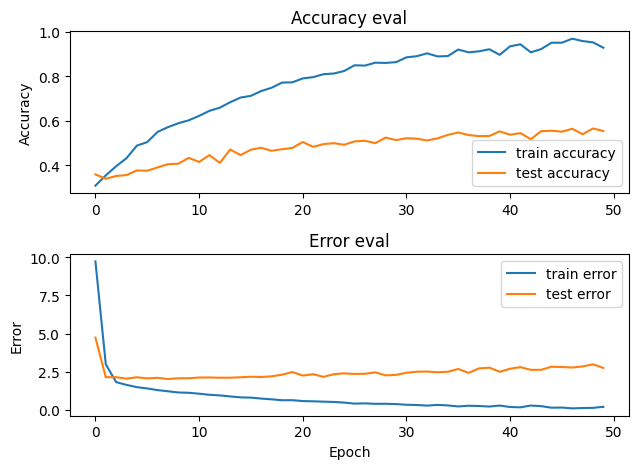

In [25]:
plot_history(history)